In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 58.6 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



#newral networks
#import tensorflow.keras as keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten

#Arima/autoarima
import sklearn
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima.arima import auto_arima
import pmdarima as pm

#Config
plt.rcParams["figure.figsize"] = (20,3)

import random
random.seed(1)

In [3]:
# Configuración Matplotlib

plt.style.use('seaborn')
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['xtick.minor.bottom'] = False
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

# Diccionario de colores que usaremos más adelante 
dayofweek_colors = {0: 'tab:blue',
                    1: 'tab:orange',
                    2: 'tab:green', 3: 'tab:red', 
                    4: 'tab:purple', 5: 'tab:brown', 
                    6: 'tab:pink'}


In [4]:
#df = pd.read_excel(r"C:\Users\Nach\Desktop\TFM\datos\datos_limpios\dataset_ventas.xlsx")
df = pd.read_excel("/content/dataset_ventas.xlsx")

In [5]:
#Convertimos los valores meteorológicos a formato float previamente sustituyendo las comas por puntos
df['prec'] = [x.replace(',','.').replace('Ip', '0') for x in df['prec']]
df['tmax'] = [x.replace(',','.') for x in df['tmax']]

In [6]:
df = df.astype({'fecha': 'datetime64[ns]','mes': 'int', 'dia': 'int', 'dia_semana': 'int','prec': 'float', 'tmax': 'float',  'ventas': 'float'}, copy=False)
df = df.drop({'mes', 'dia', 'dia_semana', 'festivo'}, axis = 1)

In [7]:
df

fecha  prec  tmax  ventas
0   2021-09-04   0.0  30.6  247.00
1   2021-09-05   0.0  32.7  172.00
2   2021-09-08   0.0  28.0   20.00
3   2021-09-09   0.0  27.1    5.00
4   2021-09-10   0.0  28.2   76.00
..         ...   ...   ...     ...
352 2022-12-18   0.0  11.3  622.80
353 2022-12-20   9.4   9.2   12.85
354 2022-12-21   0.0  14.7   20.70
355 2022-12-22   0.2  15.7  317.10
356 2022-12-23   0.0  12.6  514.00

[357 rows x 4 columns]

In [8]:
import plotly.express as px

In [9]:
fig = px.line(df, x='fecha', y='ventas', title='Ventas')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(step="all")
        ])
    )
)
fig.show()

Podemos ver ciertas estacionalidad en los datos de ventas aunque no es hasta los datos de 2022 cuando se comienza a observar más claramente. Para asegurarnos, también podemos utilizar distintos tests estadísticos, como el test Augmented Dickey-Fuller (ADF).

Si encontramos por ejemplo mediante este test que nuestros datos no son estacionarios, deberíamos ajustarlos para que lo fuesen. Auto ARIMA  lo puede hacer automáticamente.

In [10]:
#Ajustamos la fecha como índice del dataset. El modelo ARIMA necesita que la fecha sea el índice.
el_df=df.set_index('fecha')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1d8378c10>,
      dtype=object)

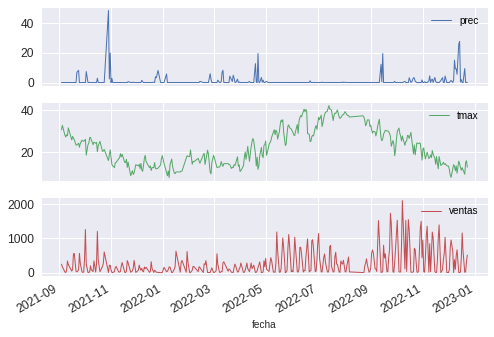

In [11]:
# Visualizando subplots
#Los subplots nos indicarán dependencias de las variables en el tiempo.

el_df.plot(subplots=True)

Las series de datos tienen muchos puntos de datos por lo que pueden ser difíciles de visualizar o analizar. Por ello necesitamos hacer un resampling de los datos ya se bien comprimiéndolos o agregándolos en intervalos de tiempo. el método resample agregará los datos en series de tiempo, en intervalos mensuales, semanales o como pretendamos ajustarlos.

In [12]:
el_df.resample('W-MON').mean()

prec       tmax      ventas
fecha                                      
2021-09-06  0.000000  31.650000  209.500000
2021-09-13  0.000000  28.500000  135.280000
2021-09-20  0.000000  26.350000  313.550000
2021-09-27  3.000000  23.360000  196.420000
2021-10-04  1.233333  24.266667  328.933333
...              ...        ...         ...
2022-11-28  1.800000  14.140000  414.780000
2022-12-05  0.440000  10.860000  356.010000
2022-12-12  6.816667  12.050000  377.266667
2022-12-19  9.283333  12.850000  376.325000
2022-12-26  2.400000  13.050000  216.162500

[69 rows x 3 columns]

In [13]:
el_df.resample('M').mean()

prec       tmax      ventas
fecha                                      
2021-09-30  0.789474  26.515789  178.178947
2021-10-31  3.677273  22.845455  275.604545
2021-11-30  0.176190  14.376190  109.519048
2021-12-31  0.760870  13.665217   80.839130
2022-01-31  0.335294  12.294118  186.311765
2022-02-28  0.523529  16.000000  109.941176
2022-03-31  1.526087  13.991304  110.771739
2022-04-30  1.492308  18.123077  137.957692
2022-05-31  0.053846  28.453846  346.598077
2022-06-30  0.046154  32.161538  378.786538
2022-07-31  0.025926  37.655556  326.648148
2022-08-31  0.014286  36.064286  159.578571
2022-09-30  1.265385  28.219231  491.615385
2022-10-31  0.526923  24.996154  685.094231
2022-11-30  0.983333  16.745833  518.885417
2022-12-31  5.420000  12.130000  358.027500

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1d30cb730>,
      dtype=object)

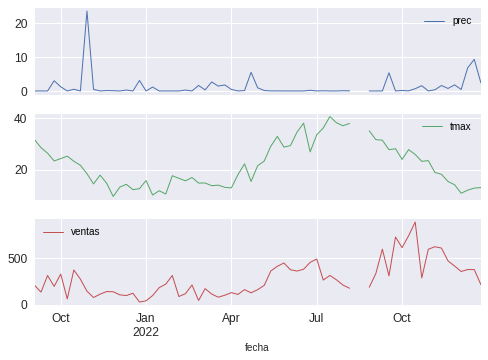

In [42]:
el_df.resample('W').mean().plot(subplots=True)

In [15]:
#Generamos los datos finales que utilizaremos para el modelo ARIMA
final_df = el_df.resample('W').mean()
final_df = final_df.fillna(value=0)
final_df

prec       tmax      ventas
fecha                                      
2021-09-05  0.000000  31.650000  209.500000
2021-09-12  0.000000  28.500000  135.280000
2021-09-19  0.000000  26.350000  313.550000
2021-09-26  3.000000  23.360000  196.420000
2021-10-03  1.233333  24.266667  328.933333
...              ...        ...         ...
2022-11-27  1.800000  14.140000  414.780000
2022-12-04  0.440000  10.860000  356.010000
2022-12-11  6.816667  12.050000  377.266667
2022-12-18  9.283333  12.850000  376.325000
2022-12-25  2.400000  13.050000  216.162500

[69 rows x 3 columns]

In [16]:
#Inicializamos la función auto_arima
model = pm.auto_arima(final_df['ventas'],  m=52, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[52]             : AIC=936.401, Time=0.50 sec
 ARIMA(0,2,0)(0,0,0)[52]             : AIC=932.928, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[52]             : AIC=891.569, Time=0.85 sec
 ARIMA(0,2,1)(0,0,1)[52]             : AIC=inf, Time=0.69 sec
 ARIMA(1,2,0)(0,0,0)[52]             : AIC=890.286, Time=0.02 sec
 ARIMA(1,2,0)(0,0,1)[52]             : AIC=891.569, Time=1.18 sec
 ARIMA(1,2,0)(1,0,1)[52]             : AIC=893.569, Time=2.46 sec
 ARIMA(2,2,0)(0,0,0)[52]             : AIC=876.125, Time=0.07 sec
 ARIMA(2,2,0)(1,0,0)[52]             : AIC=876.374, Time=1.75 sec
 ARIMA(2,2,0)(0,0,1)[52]             : AIC=876.374, Time=2.71 sec
 ARIMA(2,2,0)(1,0,1)[52]             : AIC=inf, Time=4.37 sec
 ARIMA(3,2,0)(0,0,0)[52]             : AIC=875.209, Time=0.19 sec
 ARIMA(3,2,0)(1,0,0)[52]             : AIC=875.760, Time=3.31 sec
 ARIMA(3,2,0)(0,0,1)[52]             : AIC=875.760, Time=2.09 sec
 ARIMA(3,2,0)(1,0,1)[52]             : AI

In [17]:
#El mejor modelo que encuentra es el  ARIMA(5,2,0) (p=1, d=0, and q=1)

In [18]:
#El siguiente paso consistiría en dividir el conjunto de datos en entrenamiento y tets
train=final_df[(final_df.index.get_level_values(0) >= '2021-09-05') & (final_df.index.get_level_values(0) <= '2022-10-31')]

In [19]:
test=final_df[(final_df.index.get_level_values(0) > '2022-10-31')]
test

prec       tmax      ventas
fecha                                      
2022-11-06  0.342857  18.914286  621.328571
2022-11-13  1.600000  18.183333  607.141667
2022-11-20  0.733333  15.400000  469.475000
2022-11-27  1.800000  14.140000  414.780000
2022-12-04  0.440000  10.860000  356.010000
2022-12-11  6.816667  12.050000  377.266667
2022-12-18  9.283333  12.850000  376.325000
2022-12-25  2.400000  13.050000  216.162500

In [20]:
#Entrenamos el modelo para que aprenda de nuestro data set
model.fit(train['ventas'])

ARIMA(order=(5, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 52),
      suppress_warnings=True, with_intercept=False)

In [21]:
#Usamos el modelo Auto Arima para hacer predicciones con el conjunto de test
#n_periods son el número de puntos de datos a predecir
forecast=model.predict(n_periods=8, return_conf_int=True)


In [22]:
forecast_df = pd.DataFrame(forecast[0],index = test.index,columns=['Prediction'])
forecast_df

Prediction
fecha                 
2022-11-06  362.707309
2022-11-13  446.509178
2022-11-20  474.136483
2022-11-27  177.636835
2022-12-04  339.351735
2022-12-11  138.232356
2022-12-18  187.989186
2022-12-25  153.782212

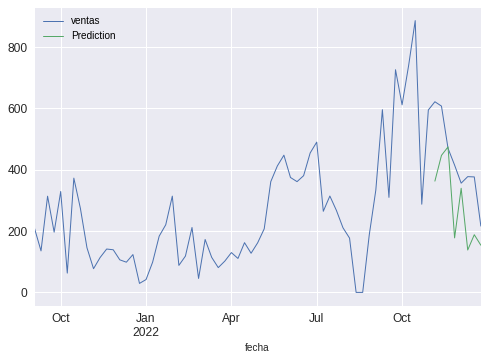

In [23]:
pd.concat([final_df['ventas'],forecast_df],axis=1).plot()

In [24]:
forecast1=model.predict(n_periods=8, return_conf_int=True)
forecast_range=pd.date_range(start='2022-10-31', periods=8,freq='W')
forecast1_df = pd.DataFrame(forecast1[0],index =forecast_range,columns=['Prediction'])

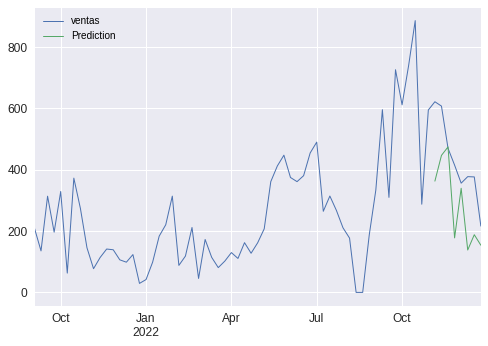

In [25]:
pd.concat([final_df['ventas'],forecast1_df],axis=1).plot()

In [41]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print('R2 Score: ', r2_score(final_df[-8:]['ventas'], forecast1_df))
print('MAE: ', mean_absolute_error(final_df[-8:]['ventas'], forecast1_df))

R2 Score:  -0.9403534555734818
MAE:  145.93338450135016
